**Group number**  
3

**Group members**  
Alexander Stoustrup  
Mathias Tyranski  
Benjamin Simonsen

In [65]:
import numpy as np
from scipy.optimize import minimize
import scipy.signal as si
import sympy as sp
import control as ct
from typing import List
from sympy.plotting import plot
import matplotlib.pyplot as plt
from IPython.display import display, Latex, Math, Image
%matplotlib inline

def eq_disp(varstring, expr, unit=""):
    display(Latex(f"${varstring}={sp.latex(expr)} \: {unit}$"))
    
def reduce_feedback(G_fwd, G_bwd):
    """Assumes feedback is deducted from signal, if not
    change sign of feedback"""
    return sp.simplify(G_fwd/(1+G_fwd*G_bwd))

def RHarray(coeffs: List):
    # first 2 rows from coefficients
    n = len(coeffs)
    arr = sp.zeros(n, n//2+2)
    i = 0
    for i in range(0,n,2):
        arr[0, i//2] = coeffs[i]
    for i in range(1,n,2):
        arr[1, i//2] = coeffs[i]

    for j in range(2, arr.shape[0]):
        for i in range(arr.shape[1]-1):
            a0 = arr[j-2,0]
            a3 = a1 = arr[j-1,i+1]
            a1 = arr[j-1,0]
            a2 = arr[j-2,i+1]
            arr[j, i] = (a1*a2-a0*a3)/a1
    return arr

# P9.21

In [66]:
K, s = sp.symbols('K, s')
L = K/(s*(s+1)*(s+4))
eq_disp('L(s)', L)
T = reduce_feedback(L, 1)
eq_disp('T(s)', T)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## a) Bode plot

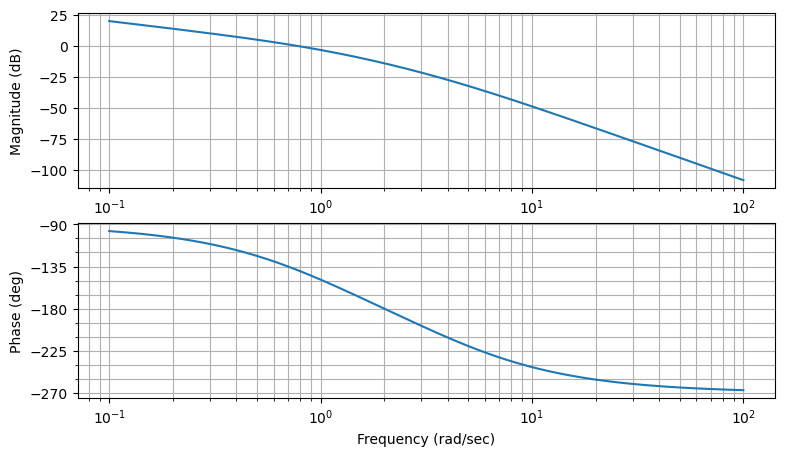

In [67]:
K = 4
s = ct.tf('s')
sys = K/(s*(s+1)*(s+4))

fig, ax = plt.subplots(figsize=(9, 5))
mag, phase, omega = ct.bode(sys, dB=True)

## b) Gain margin

Rewriting the loop transfer function to the frequency domain on the following form to be able to extract $\tau_1$ and $\tau_2$
$$L(j\omega) = \frac{K}{j \omega\left(j \omega \tau_1+1\right)\left(j \omega \tau_2+1\right)}$$

In [68]:
K, s, j, omega = sp.symbols('K, s, j, omega')
L = K*(1/4)/(j*omega*(j*omega+1)*(j*omega/4+1))
eq_disp('L(s)', L)

<IPython.core.display.Latex object>

With

In [69]:
tau1 = 1/4
tau2 = 1
K = 4
eq_disp('\\tau_1', tau1)
eq_disp('\\tau_2', tau2)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Evaluating the gain margin by
\begin{equation}
G.M.=20log\left(\left[\frac{K \tau_1 \tau_2}{\tau_1+\tau_2}\right]^{-1}\right)
\label{eq:GM}
\end{equation}

In [70]:
GM_K4 = (20*sp.log((K*0.25*tau1*tau2/(tau1 + tau2))**(-1), 10)).evalf()
eq_disp('G. M.(K=4)', round(GM_K4,1), 'dB')

<IPython.core.display.Latex object>

## c) K providing gain margin of 12 dB

Eq. \ref{eq:GM} is solved for $K$ with a gain margin of $12 dB$
$$12 dB=20log\left(\left[\frac{K \tau_1 \tau_2}{\tau_1+\tau_2}\right]^{-1}\right)$$

In [71]:
K = sp.symbols('K')
K_12 = sp.solve(20*sp.log((K*0.25*tau1*tau2/(tau1 + tau2))**(-1), 10) - 12, K)[0]
eq_disp('K(G.M.=12 dB)', round(K_12, 1))

<IPython.core.display.Latex object>

## d) K for steady-state error of 25 % of the magnitude $A$ for ramp input

In [72]:
K, s, A = sp.symbols('K, s, A')
L = K/(s*(s+1)*(s+4))
eq_disp('L(s)', L)

<IPython.core.display.Latex object>

In [73]:
R = A*1/s**2
E = sp.simplify(R/(1 + L))
eq_disp('E(s)', E)

<IPython.core.display.Latex object>

$$e_{ss}=\lim_{s \to 0} sE(s)$$

In [74]:
e_ss = sp.limit(sp.simplify(s*E), s, 0)
eq_disp('e_{ss}', e_ss)

<IPython.core.display.Latex object>

With
$$e_{ss} = 0.25A$$

In [75]:
K_25p = sp.solve(e_ss - 0.25*A, K)[0]
eq_disp('K(e_{ss}=0.25A)', K_25p)

<IPython.core.display.Latex object>

### Checking if this K results in a stable system

Finding the coefficients of the denominator

In [76]:
p, q = T.as_numer_denom()

coeffs = sp.Poly(q, s).coeffs()
eq_disp('q(s)', sp.Poly(q, s))
for i, k in enumerate(coeffs):
    display(Latex(f"${f's^{len(coeffs)-1-i}'}: {sp.latex(k)}$"))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Finding Routh-Hurwitz array

In [77]:
arr = RHarray(coeffs)
arr

Matrix([
[      1, 4, 0, 0],
[      5, K, 0, 0],
[4 - K/5, 0, 0, 0],
[      K, 0, 0, 0]])

So when the two roots lie on the imaginary axis the gain is

In [78]:
K_mstable = sp.solve(arr[2,0], K)[0]
eq_disp('K', K_mstable)

<IPython.core.display.Latex object>

For $K<20$ the system will be stable so this gain can be utilized and achieve acceptable performance

# AP9.11

In [79]:
s = sp.symbols('s')
t = sp.symbols('t', positive=True)
T_delay = 1 #s
PO_max = 0.1
Gc = 5/(s*(s + 10))
G = sp.exp(-s*T_delay)
T = reduce_feedback(Gc*G, 1)
eq_disp('G_c(s)', Gc)
eq_disp('G(s)', G)
eq_disp('T(s)', T)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Ignoring the time delay

In [80]:
T_ndelay = reduce_feedback(Gc, 1)
eq_disp('T(s)', T_ndelay)

<IPython.core.display.Latex object>

In [81]:
R = 1/s
Y_ndelay = R*T_ndelay
y_ndelay = sp.inverse_laplace_transform(Y_ndelay, s, t)
eq_disp('y(t)', y_ndelay)

<IPython.core.display.Latex object>

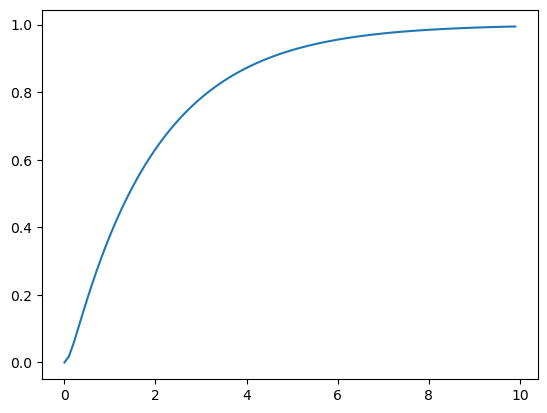

In [82]:
y_plot = sp.lambdify(t, y_ndelay)
t_span = np.r_[0:10:0.1]
plt.plot(t_span, y_plot(t_span))

With the time delay:

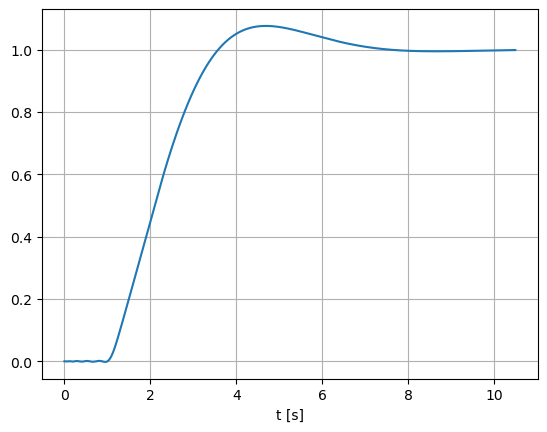

In [83]:
# Make padé approximation of time delay
# 10th order approximation
n_pade = 10
num_pade, den_pade = ct.pade(T_delay, n_pade)
H_pade = ct.tf(num_pade, den_pade)

s = ct.tf('s')
Gc = 5/(s*(s + 10))

# Connect Gc and time delay in series to get loop function
L = ct.series(Gc, H_pade)

# Reduce feedback loop
T = ct.feedback(L, 1)

# Get step response
t, y = ct.step_response(T)

# Plot
plt.plot(t, y)
plt.xlabel('t [s]')
plt.grid ()

The steadu state error is approximated

In [84]:
e_ss = 1 - y[-1]
eq_disp('e_{ss}', round(e_ss,2))

<IPython.core.display.Latex object>

The percent overshoot
$$P.O. = \frac{y(T_p) - y(\infty)}{y(\infty)}$$
is found

In [85]:
PO = (np.max(y) - 1)/1
eq_disp('P.O.', round(PO,3)*100, '\\%')

<IPython.core.display.Latex object>

So the percent overshoot and steady state error specifications are satisfied.

Next, we find the gain margin, phase margin and cut-off frequencies of each of them. The time delay results in a phase shift so we find the margins for the controller transfer function

In [86]:
gm, pm, wcg, wcp = ct.margin(Gc)

We get the phase margin and the cut-off frequency for the phase margin

In [87]:
eq_disp('\\phi_{pm}', round(pm,1), '^\\circ')
eq_disp('\\omega_{cp}', round(wcp,2), 'rad/s')

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

The critical time delay is
$$T_c = \frac{\phi_{pm}}{\omega_{cp}}$$

In [88]:
T_c = pm/(wcp*180/np.pi)
eq_disp('T_c', round(T_c,4))

<IPython.core.display.Latex object>

So
$$T \leq T_c = \frac{\phi_{pm}}{\omega_{cp}}$$

The time delay $e^{-sT}$ results in a phase shift
$$\phi(\omega) = -\omega T$$

Text(0, 0.5, '$\\phi_{pm}$ $[^\\circ]$')

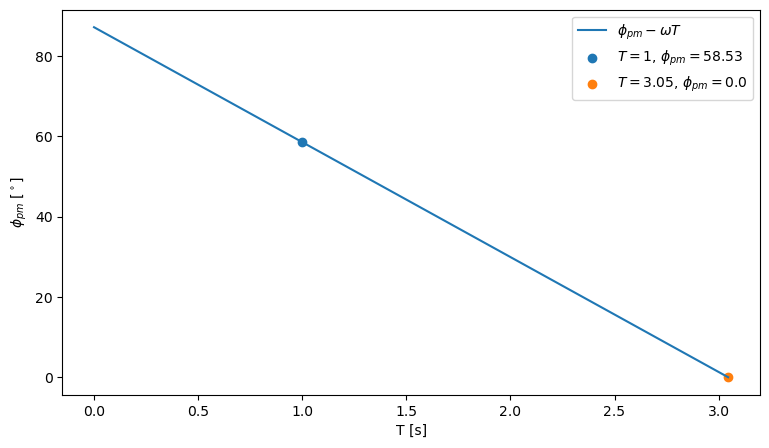

In [89]:
phi = lambda T_d: T_d*wcp*180/np.pi
T_span = np.r_[0:5:T_c]

fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(T_span, pm-phi(T_span))
ax.scatter(T_delay, pm-phi(T_delay))
ax.scatter(T_c, pm-phi(T_c))
ax.legend(['$\phi_{pm}-\omega T$', f'$T={round(T_delay,2)}$, ' + '$\phi_{pm}=$' + f'{round(pm-phi(T_delay),2)}', f'$T={round(T_c,2)}$, ' + '$\phi_{pm}=$' + f'{round(pm-phi(T_c),2)}'])
ax.set_xlabel('T [s]')
ax.set_ylabel('$\phi_{pm}$ $[^\circ]$')

# DP9.1

## a)

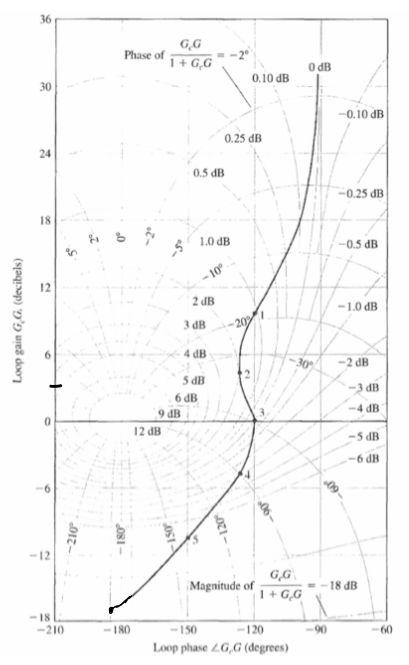

In [90]:
Image('Gain and phase margin.png', width='400px')

From the plot the gain and phase margins are read

In [91]:
GM = 17
PM = 60
eq_disp('G.M.', GM, 'dB')
eq_disp('P.M.', PM, '^\\circ')

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## b)

The resonant peak is found at point 2 on the plot. Here the resonant peak and frequency are

In [92]:
Mp = 2
omega_p = 5
eq_disp('M_p', Mp, 'dB')
eq_disp('\\omega_p', omega_p, 'rad/s')

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## c)

The bandwidth is at point 4, where the curve crosses the $-3 dB$ curve

In [93]:
omega_B = 20
eq_disp('\\omega_B', omega_B, 'rad/s')

<IPython.core.display.Latex object>

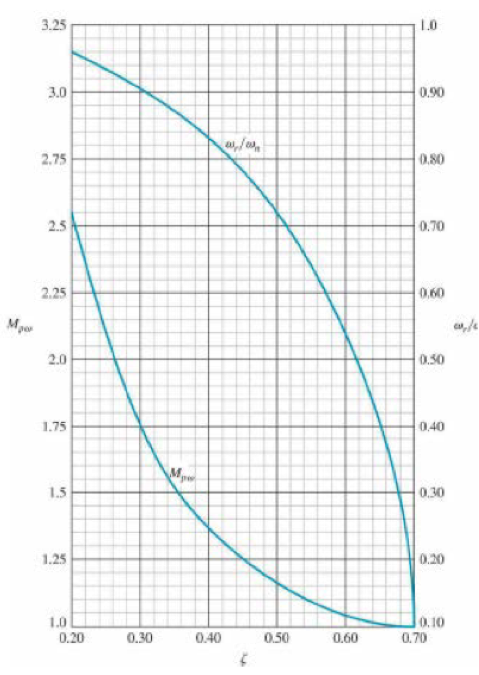

In [94]:
Image('Resonant peak, frequency and damping ratio.png')

Converting the resonant peak to linear scale

In [95]:
Mp_lin = 10**(Mp/20)
eq_disp('M_p', round(Mp_lin,2))

<IPython.core.display.Latex object>

So we get the damping ratio and the ratio of the resonant frequency to the natural frequency

In [96]:
xi = 0.45
wr_pr_wn = 0.69
eq_disp('\\xi', xi)
eq_disp('\\frac{\\omega_r}{\\omega_n}', wr_pr_wn)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

So the natural frequency and thereby the settling time are

In [97]:
wn = omega_p/wr_pr_wn
Ts = 4/(xi*wn)
eq_disp('\\omega_n', round(wn,2), 'rad/s')
eq_disp('T_s', round(Ts,2), 's')

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

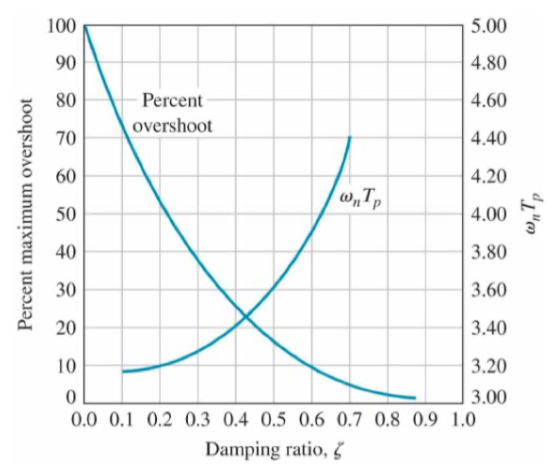

In [98]:
Image('PO.png')

So the percent overshoot is

In [99]:
PO = 0.2
eq_disp('P.O.', PO*100, '\\%')

<IPython.core.display.Latex object>

## d)

The P.O. of 30 % is equivalent to a damping ratio of

In [100]:
xi = 0.35
xi

0.35

In [101]:
Mp = 20*np.log10(1.5)
Mp

3.5218251811136247

The first plot shows $G_c(j\omega) G(j\omega)/K$. So we need to lower the gain by approximately 10 dB to land between the closed loop line of -3 and -4 dB.

# DP9.9

# a)

The transferfunction is given by

In [102]:
s, A, Kp, K1, T2d, T0, G1s, G2s, Gcs = sp.symbols(r's, A, K_p, K1, T_{2d}, T0, G_1, G_2, G_c')
tau1 = 10
tau2 = 50
G1 = 1/100/((tau1*s+1)*(tau2*s+1))
G2 = 1/((tau1*s+1)*(tau2*s+1))
Gc = Kp + K1/s
T2 = reduce_feedback(Gcs*G1s,1)*T2d + reduce_feedback(1, Gcs*G1s)*G2s*T0
eq_disp('T_2', T2)

<IPython.core.display.Latex object>

## b)

Assuming $A=1$ we can plot the response of the system

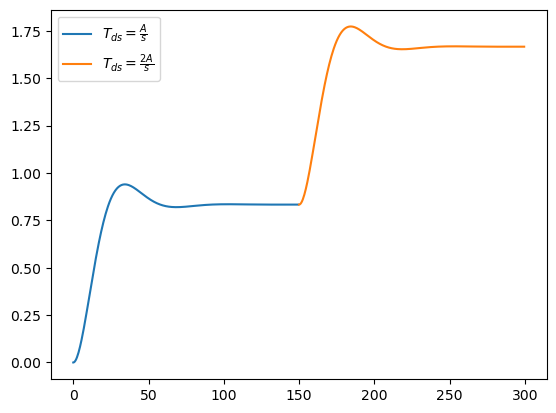

In [103]:
s = ct.tf('s')
G1 = 1/100/((tau1*s+1)*(tau2*s+1))
G2 = 1/((tau1*s+1)*(tau2*s+1))
Gc = 500
T2 = ct.feedback(Gc*G1, 1)
t1, y1 = ct.step_response(T2, np.r_[0:150:0.5])
t2, y2 = ct.step_response(T2+T2.dcgain(), np.r_[150:300:0.5])
plt.plot(t1, y1)
plt.plot(t2, y2)
plt.legend([r"$T_{ds}=\frac{A}{s}$", r"$T_{ds}=\frac{2A}{s}$"])
plt.show()

## c)

The steady state error for $T_{ds}=\frac{2}{s}$ is given by

In [104]:
e_ss = 2-(T2+T2.dcgain()).dcgain()
eq_disp("e_{ss}", round(e_ss,3))

<IPython.core.display.Latex object>

## d)

From the figure the damping ratio must be $\zeta>0.6$

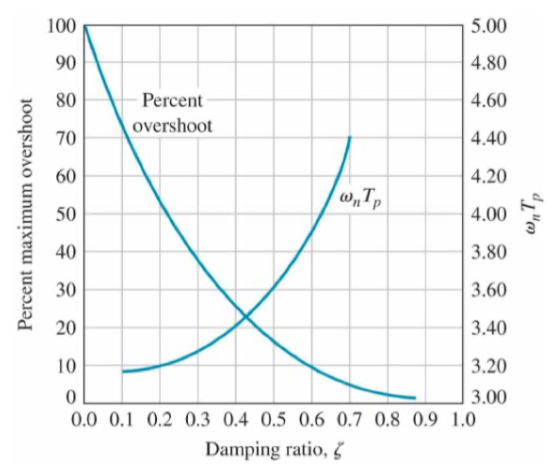

In [105]:
Image('PO.png')

In [106]:
Gc = 1/s
L = Gc*G1
L

TransferFunction(array([0.01]), array([500,  60,   1,   0]))

We plot the damping ratio requirement on the root locus and determine the gain

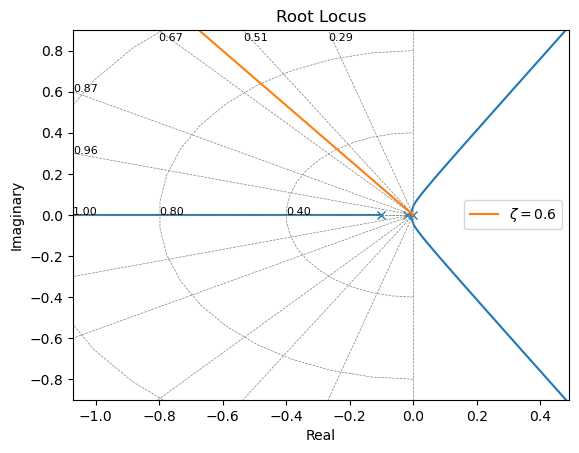

In [107]:
zeta = 0.6
theta = np.arcsin(zeta)
a = -np.cos(theta)/np.sin(theta)
tspan = np.r_[0:-10:-1]
damp = a*tspan
a = ct.root_locus(L)
handle= plt.plot(tspan, damp, label=r"$\zeta=0.6$")
plt.legend(handles=handle)


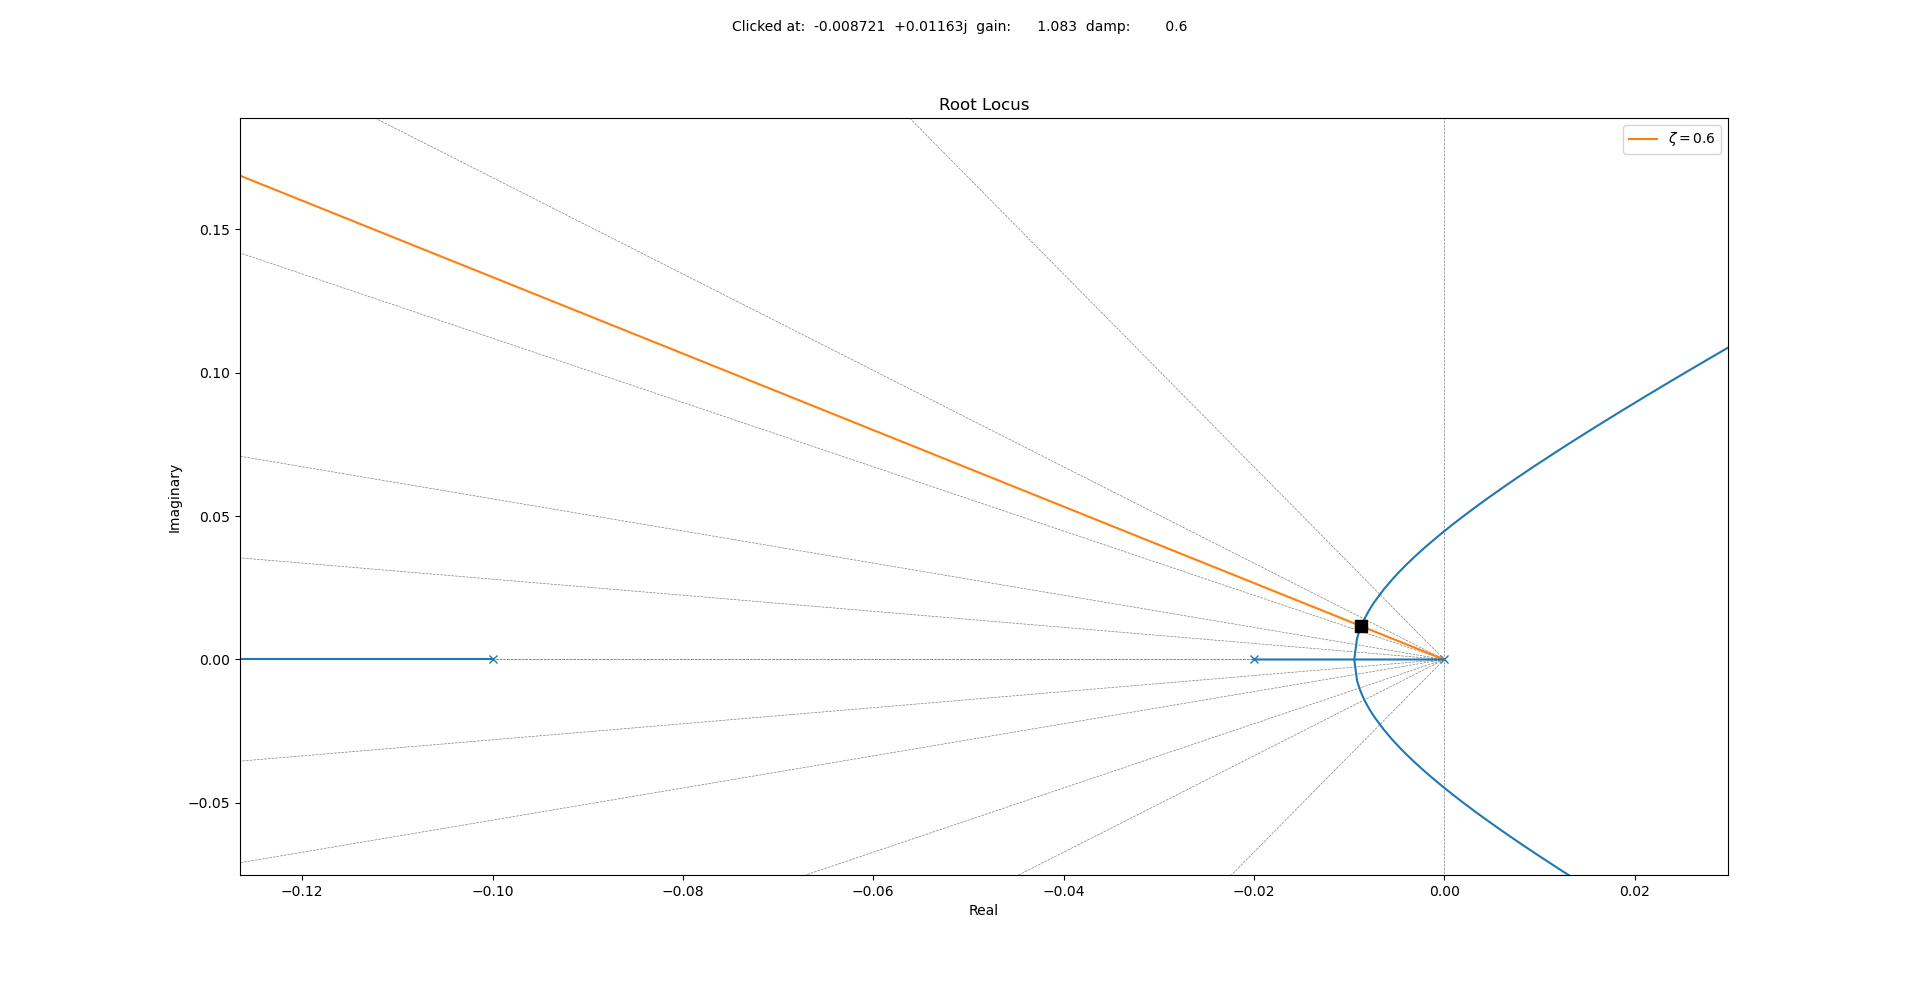

In [108]:
Image("DP9_9.png")

From the root locus we can see that the gain must be $K<1.089$ to meet the calculated damping ratio criteria.  
We chose $K=1$

In [109]:
Gc=1/s
T = ct.feedback(Gc*G1, 1)
ct.step_info(T)

{'RiseTime': 140.28630808602514,
 'SettlingTime': 439.74361957734806,
 'SettlingMin': 0.9022355487060528,
 'SettlingMax': 1.0770685327703315,
 'Overshoot': 7.706853277033154,
 'Undershoot': 0,
 'Peak': 1.0770685327703315,
 'PeakTime': 300.8062182998424,
 'SteadyStateValue': 1.0}

We can see that the desired overshoot is now met

We can now plot the result as in b) for a unit step input

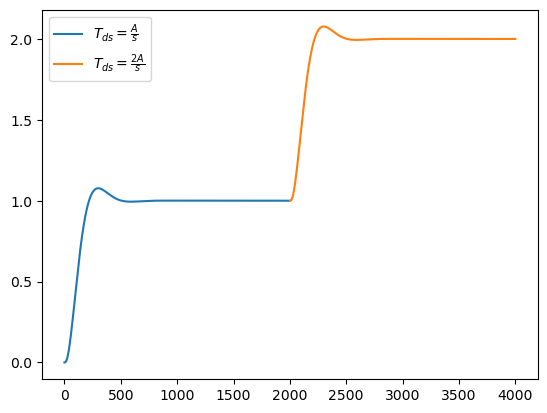

In [110]:
t1, y1 = ct.step_response(T, np.r_[0:2000:0.5])
t2, y2 = ct.step_response(T+T.dcgain(), np.r_[2000:4000:0.5])
plt.plot(t1, y1)
plt.plot(t2, y2)
plt.legend([r"$T_{ds}=\frac{A}{s}$", r"$T_{ds}=\frac{2A}{s}$"])
plt.show()

The steady state error for $T_{ds}=\frac{2}{s}$ is given by

In [111]:
e_ss = 2-(T+T.dcgain()).dcgain()
eq_disp("e_{ss}", round(e_ss,3))

<IPython.core.display.Latex object>

## e)

From the settling time and overshoot requirement, we can find the desired $\zeta$ and $\omega$, then we can find the equivalent ideal pole position of the second order system

In [112]:
s = ct.tf('s')
Ts=150
zeta = 0.6
omega = 4/(Ts*zeta)

We plot the root locus of the plant with the constraint lines that represents the system requirements

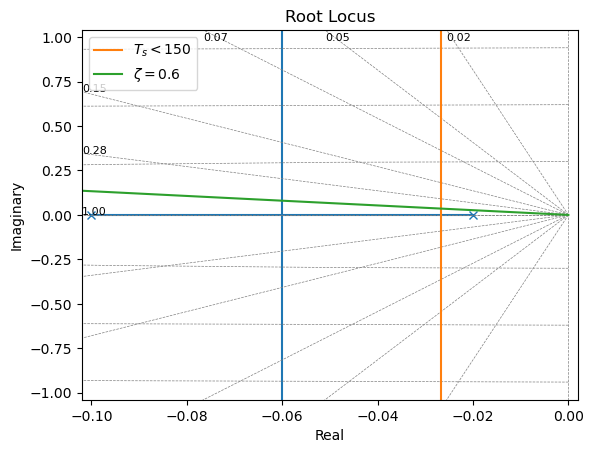

In [114]:
b = ct.root_locus(G1)
theta = np.arcsin(zeta)
a = -np.cos(theta)/np.sin(theta)
tspan = np.r_[0:-2000:-1]
damp = a*tspan
handles= []
handles.append(*plt.plot(np.array([-omega*zeta, -omega*zeta]), np.array([-1500, 1500]), label=f"$T_s<{round(Ts,3)}$"))
handles.append(*plt.plot(tspan, damp, label=r"$\zeta=0.6$"))
plt.legend(handles=handles)

The ideal pole placement of second order system is given by:

In [115]:
dp = complex(-zeta*omega, (omega)*np.sqrt(1-zeta**2))
dp

(-0.02666666666666667+0.035555555555555556j)

From the magnitude and the angle criterion we can determine the controller pole placement and gain, that will result in the desired pole position

In [116]:
plant_poles = (G1*1/s).poles()
plant_zeros = (G1*1/s).zeros()

In [117]:
p_angles = []
p_mag = []
for p in plant_poles:
    p_angles.append(np.angle(dp - p, deg=True))
    p_mag.append(np.abs(dp - p))

Apply the angle criterion to determine the controler pole location

In [121]:
z_angle = (180 + sum(p_angles))%360
z = sp.symbols('z')
z = float(sp.solve(np.tan(z_angle*np.pi/180) - dp.imag/(dp.real+z), z)[0])
eq_disp('z', z)

<IPython.core.display.Latex object>

Apply magnitude criterion to determine the gain

In [122]:
K = abs(dp+z)/np.prod(p_mag)
eq_disp('K',K)

<IPython.core.display.Latex object>

Lastly the step response is plotted. 
Through trial and error the pole position is decreased to half, to  meet the requirements

{'RiseTime': 26.967260104194203,
 'SettlingTime': 75.50832829174377,
 'SettlingMin': 0.9130208737447244,
 'SettlingMax': 1.0449291014062252,
 'Overshoot': 4.492910140622519,
 'Undershoot': 0,
 'Peak': 1.0449291014062252,
 'PeakTime': 56.63124621880783,
 'SteadyStateValue': 1.0}

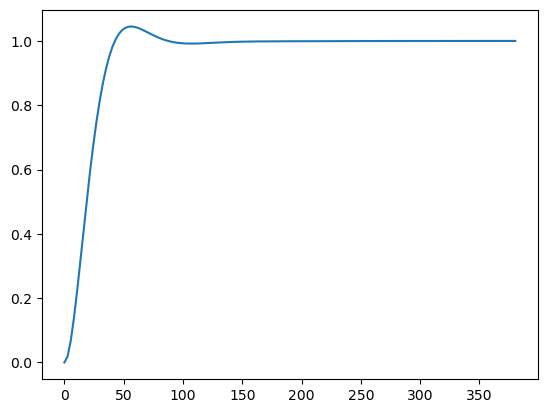

In [120]:
T = ct.feedback(G1*K*(s+z*0.5)/s)
plt.plot(*ct.step_response(T))
ct.step_info(T)